# **Anomaly Detection**

There a several useful anomaly detection methods here.

## **Algorithms**

Currently there are **four** flavours implemented here:

 * **ThresholdingAnomalyDetector**: Uses a moving average and standard deviation filter to estimate the expected value ranges of the time series at each point in time. If a data point falls outside a certain number of standard deviations from the moving average, it is considered an anomaly.
 
 * **EMAAnomalyDetector**: This is the same as above but has an additional paramater, `alpha`, which determines the degree of weighting for recent data points compared to older data points. More detail later on.
 
 * **ARIMAAnomalyDetector**: This model works differently from those above, and has an additional parameter, `order`, which determines the Auto-Regressive, Integration, and Moving Average fit for an ARIMA model. The model then predicts the values of the time series dataset. The residuals are calculated by subtracting the predicted values from the actual values. Residuals represent the error in prediction. The standard deviation of the residuals is then computed. The algorithm identifies an observation as an anomaly if the absolute value of its residual is greater than a certain threshold times the standard deviation of residuals. 
 
 * **RealTimeAnomalyDetector**: This implementation uses only the data available at the time of detection, therefore produces different results that the algorithms above. Uses loginc similar to ThresholdingAnomalyDetector.


# **Example Usage**

This threshold based anomaly detection algorithms works by identifying data points that significantly deviate from the expected pattern of a time series. 


If we take ThresholdingAnomalyDetector as an example. It does this by using a moving average and standard deviation filter to estimate the expected value ranges of the time series at each point in time. **If a data point falls outside a certain number of standard deviations from the moving average, it is considered an anomaly.**

Here's a step-by-step explanation of how the algorithm works:

* Calculate the moving average and standard deviation of the time series over a window of a fixed size (specified by the lag parameter).
* Calculate the upper and lower bounds for the time series values based on the moving average and standard deviation, using a threshold specified by the threshold parameter.
* For each data point in the time series, calculate whether it is outside the upper or lower bounds.
* If a data point is outside the bounds, mark it as an anomaly by assigning it a value of +1 or -1 (depending on whether it is above or below the upper or lower bound, respectively).
* If a data point is not outside the bounds, it is considered normal and assigned a value of 0.
* Optionally, smooth the time series by replacing anomalous values with a weighted average of the previous value and the current value, where the weight is specified by the influence parameter.
* Repeat steps 1-6 for the rest of the time series.


We can express it:

$$\text{is_outlier} = \begin{cases}1 & \text{if } |y_i - \text{Moving Average}_{i-1}| > k \times \text{Standard Deviation}_{i-1}\\-1 & \text{if } |y_i - \text{Moving Average}_{i-1}| < k \times \text{Standard Deviation}_{i-1}\\0 & \text{otherwise}\end{cases}$$

In [2]:
%load_ext autoreload
%autoreload 2

from effective_anomaly_detection import *
import pandas as pd
import numpy as np

# for interactive visual later
import ipywidgets as widgets
from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **Generate sample data**

In [3]:
df = pd.DataFrame(generate_syntehtic_timeseries(1_000), columns=['Time_Series'])

# Isolate the feature of interest
y = df["Time_Series"]

## **Define Parameters**

For the purposes of dmeonstration, we'll use the same `config` for all algorithms.

In [4]:
LAG = 10
N_STANDARD_DEVIATIONS = 3
ANOMALY_INFLUENCE = 0.5

## **Initialize the AnomalyDetectorConfig object**

In [5]:
config = AnomalyDetectorConfig(LAG, N_STANDARD_DEVIATIONS, ANOMALY_INFLUENCE)

The current implemenation accepts `numpy` arrays and `pandas` series.

## **ThresholdingAnomalyDetector**

In [6]:
# Call the thresholding algorithm
anomDetector = ThresholdingAnomalyDetector(config)
results = anomDetector.run(y)

In [7]:
pd.DataFrame.from_dict(results).assign(y_values=y).tail(3)

,signals,avgFilter,stdFilter,y_values
997,0,99.403841,0.566420,99.857391
998,0,99.374120,0.572614,99.121698
999,0,99.398205,0.584805,99.799529


### **Plot Results**

You can access the algorithm results directly, but of course plotting the results gives a good indication.

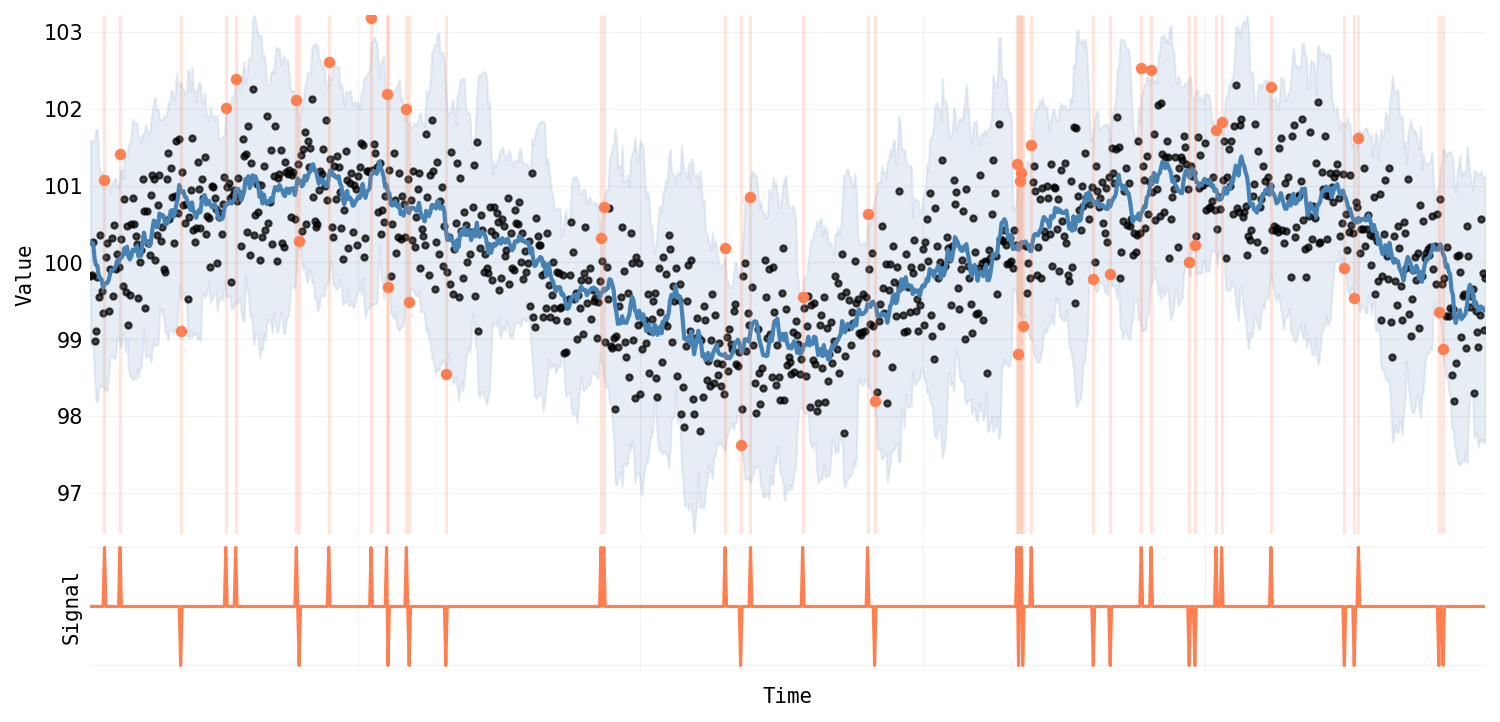

In [8]:
# Plot the results
fig = anomDetector.plot(y, results)

## **EMAAnomalyDetector**

The EMAAnomalyDetector class is an anomaly detector that uses Exponential Moving Average (EMA) and standard deviation as a thresholding technique to detect anomalies in a given dataset.

The alpha parameter in the EMAAnomalyDetector class is a crucial part of the Exponential Moving Average calculation. It determines the degree of weighting for recent data points compared to older data points. The alpha value ranges between 0 and 1, and it impacts the EMA calculation as follows:

 * When alpha is close to 0, more weight is given to older data points, making the EMA less sensitive to recent changes in the data. In the extreme case of alpha = 0, the EMA would be equal to the first data point, and it wouldn't be updated with new data points.

* When alpha is close to 1, more weight is given to recent data points, making the EMA more sensitive to recent changes in the data. In the extreme case of alpha = 1, the EMA would be equal to the most recent data point, effectively ignoring the historical data.

In [9]:
anomDetector = EMAAnomalyDetector(config, alpha=0.5)
results = anomDetector.run(y)

### **Plot Results**

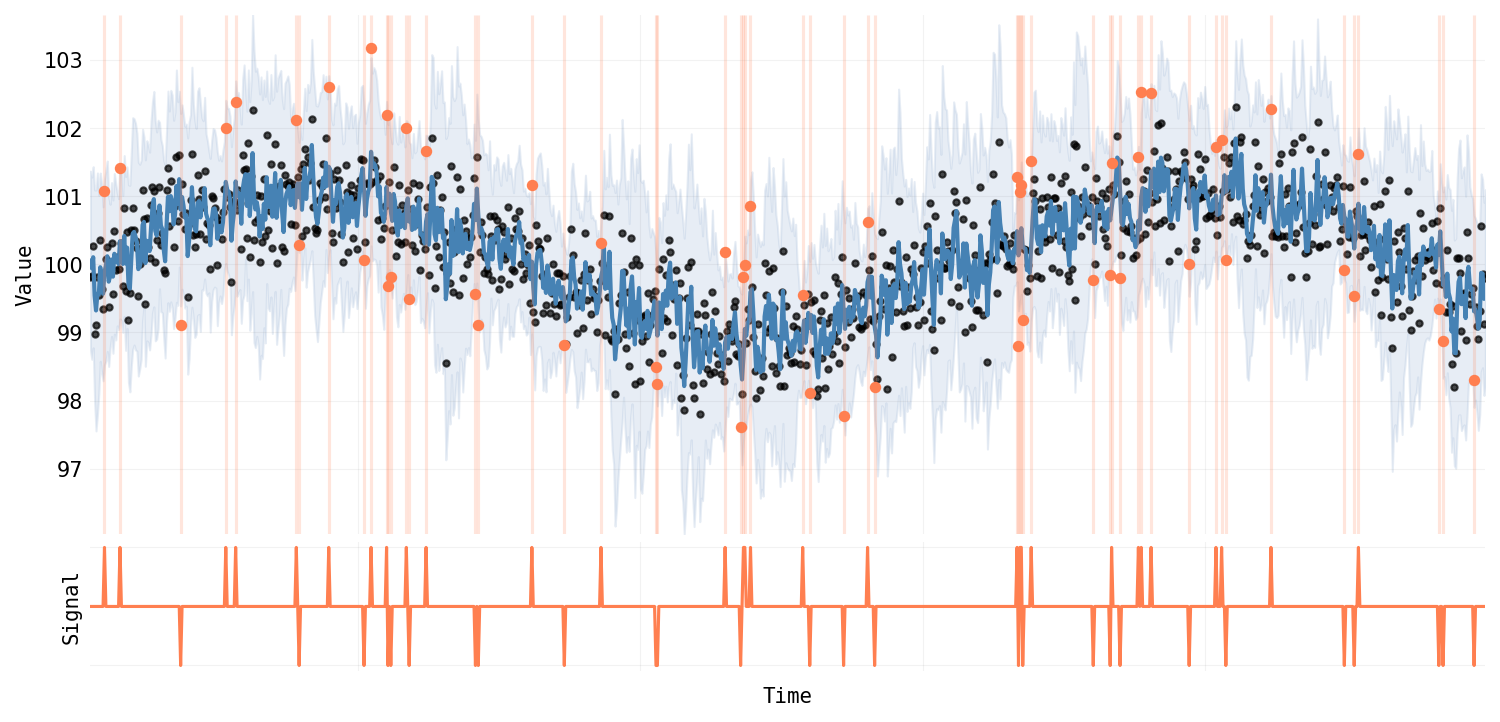

In [10]:
fig = anomDetector.plot(y, results)

## **ARIMAAnomalyDetector**

Note that the order should be selected wisely. This will depend on your dataset.

In [32]:
anomDetector = ARIMAAnomalyDetector(config, order=(1, 1, 0))
results = anomDetector.run(y)
print("Prediction RMSE:\t",anomDetector.rmse_metric(results["residuals"]))

Prediction RMSE:	 0.4192987074390508


### **Plot Results**

Note that the ARIMA plot also displays residuals, ie. (prediction - actual).

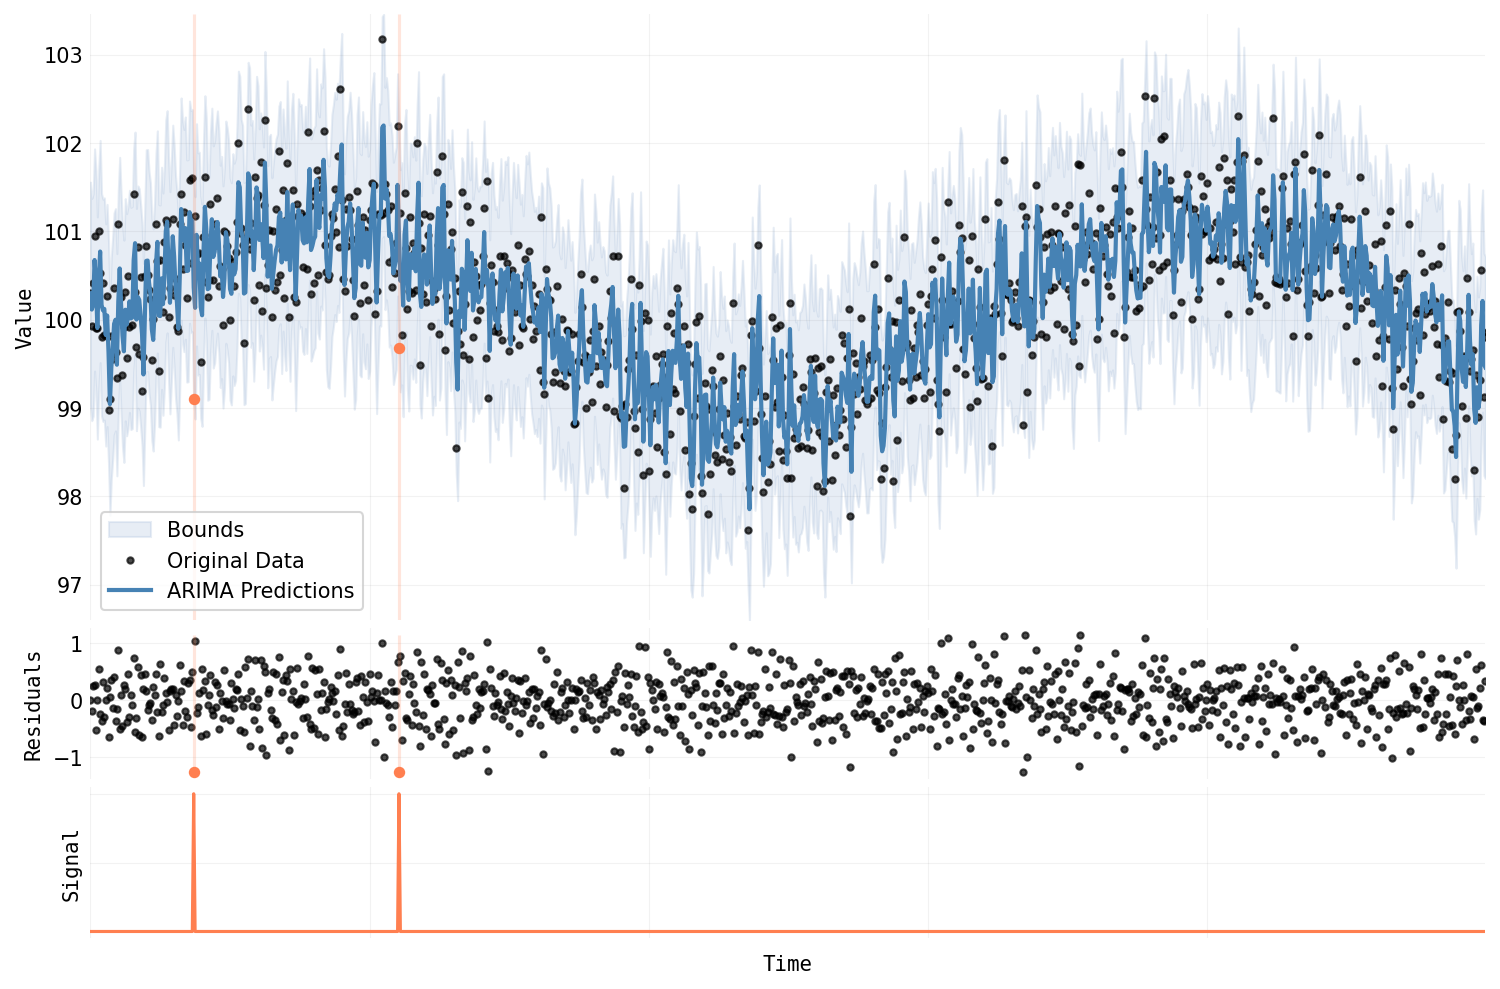

In [30]:
fig = anomDetector.plot(y, results)

## **RealTimeAnomalyDetector**

Sometimes we may want to apply this algorithm in real-time. Ie. We do not want to have to compute the historic data each time.

In [11]:
realTimeDetector = RealTimeAnomalyDetector(config)

# Simulate incoming data stream
real_time_signals = []
for data in y[:20]:
    signal = realTimeDetector.run(data)
    real_time_signals.append(signal)

## **Interactive Plotting**

To understand each parameters' impact on the various algorithms, it can be useful to explore with a **interactive visualization**.

**ThresholdingAnomalyDetector**

In [12]:
def interactive_thresholding(y, lag=5, threshold=3.5, influence=0.5):
    config = AnomalyDetectorConfig(lag=lag, threshold=threshold, influence=influence)
    anomDetector = ThresholdingAnomalyDetector(config)
    results = anomDetector.run(y)
    fig = anomDetector.plot(y, results)

# Create sliders for lag, threshold, and influence
lag_slider = widgets.IntSlider(min=1, max=40, step=1, value=LAG, description='Lag:')
threshold_slider = widgets.FloatSlider(min=0, max=10, step=0.25, value=N_STANDARD_DEVIATIONS, description='Threshold:')
influence_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=ANOMALY_INFLUENCE, description='Influence:')

# Display the interactive plot
widgets.interact(interactive_thresholding, y=widgets.fixed(y), lag=lag_slider, threshold=threshold_slider, influence=influence_slider)

interactive(children=(IntSlider(value=10, description='Lag:', max=40, min=1), FloatSlider(value=3.0, descripti…

<function __main__.interactive_thresholding(y, lag=5, threshold=3.5, influence=0.5)>

Now explore the **EMAAnomalyDetector** paramerers

In [13]:
def interactive_thresholding_ema(y, lag=5, threshold=3.5, influence=0.5, alpha=0.01):
    config = AnomalyDetectorConfig(lag=lag, threshold=threshold, influence=influence)
    anomDetector = EMAAnomalyDetector(config, alpha)
    results = anomDetector.run(y)
    fig = anomDetector.plot(y, results)

# Create sliders for lag, threshold, and influence
lag_slider = widgets.IntSlider(min=1, max=40, step=1, value=LAG, description='Lag:')
threshold_slider = widgets.FloatSlider(min=0, max=10, step=0.25, value=N_STANDARD_DEVIATIONS, description='Threshold:')
influence_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=ANOMALY_INFLUENCE, description='Influence:')
alpha_slider = widgets.FloatSlider(min=0.01, max=1, step=0.01, value=0.5, description='Alpha:')

# Display the interactive plot
widgets.interact(interactive_thresholding_ema, y=widgets.fixed(y), lag=lag_slider, threshold=threshold_slider, influence=influence_slider, alpha=alpha_slider)


interactive(children=(IntSlider(value=10, description='Lag:', max=40, min=1), FloatSlider(value=3.0, descripti…

<function __main__.interactive_thresholding_ema(y, lag=5, threshold=3.5, influence=0.5, alpha=0.01)>

And we can explore the parameters for **ARIMA** too

In [14]:
def interactive_thresholding_ema(y, lag=5, threshold=3.5, influence=0.5, o1=1, o2=1, o3=1):
    config = AnomalyDetectorConfig(lag=lag, threshold=threshold, influence=influence)
    anomDetector = ARIMAAnomalyDetector(config, (o1, o2, o3))
    results = anomDetector.run(y)
    print(anomDetector.rmse_metric(results["residuals"]))
    fig = anomDetector.plot(y, results)

# Create sliders for lag, threshold, and influence
lag_slider = widgets.IntSlider(min=1, max=40, step=1, value=LAG, description='Lag:')
threshold_slider = widgets.FloatSlider(min=0, max=10, step=0.25, value=N_STANDARD_DEVIATIONS, description='Threshold:')
influence_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=ANOMALY_INFLUENCE, description='Influence:')
o1_slider = widgets.FloatSlider(min=0, max=12, step=1, value=1, description='O1 - AutoRegression:')
o2_slider = widgets.FloatSlider(min=0, max=12, step=1, value=1, description='O2 - Integration (Differencing):')
o3_slider = widgets.FloatSlider(min=0, max=12, step=1, value=1, description='O3 - Moving Avg:')

# Display the interactive plot
widgets.interact(interactive_thresholding_ema, y=widgets.fixed(y), lag=lag_slider, threshold=threshold_slider, influence=influence_slider, o1=o1_slider, o2=o2_slider, o3=o3_slider)


interactive(children=(IntSlider(value=10, description='Lag:', max=40, min=1), FloatSlider(value=3.0, descripti…

<function __main__.interactive_thresholding_ema(y, lag=5, threshold=3.5, influence=0.5, o1=1, o2=1, o3=1)>